In [78]:
import numpy as np
import pandas as pd
from google.colab import drive
import datetime as dt
drive.mount('/drive')
from sklearn.preprocessing import LabelEncoder 
import pickle
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from matplotlib import rcParams
from scipy import stats
sns.color_palette("light:b", as_cmap=True)
import xgboost as xgb
%matplotlib inline

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/loans_full_schema.csv')

In [5]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


# **DATASET DESCRIPTION**

Lending Club is an online peer-to-peer credit marketplace that matches borrowers with investors. For evaluating the creditworthiness of theirborrowers, Lending Club relies on many factors related to borrowers such as credit history, employment, income, ratings, etc. The lending club then assigns rating/sub-rating to their borrowers based on their credit history. This rating information is then made available to investors who fund the loan requests and use this information to analyze loan requests and adjudicate the approved amount. In addition to the grade information, Lending Club provides historical loan performance data to investors for more comprehensive analysis. In short, our dataset contains a total of 10,000 records with 55 attributes in a comma-separated file. Each record in the file represents a loan request. This dataset has different types of features such as categorical, continuous, numerical, etc.



# **Issues With Dataset**

In [6]:
df.describe()

,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,9183.000000,1.000000e+04,9976.000000,1.495000e+03,1495.000000,10000.00000,4342.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,2285.000000,10000.0000,10000.000000,10000.000000,10000.000000,8729.000000,10000.000000,9682.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,11.40440,1.836062e+05,51049.063100,0.013800,0.167100,46.112473,0.0001,184.334000,2.663600,4.376100,7.340703,11.379600,0.0,0.0001,3.595300,27357.410300,13.030000,8.095000,5.230500,1.383100,94.648990,0.043300,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.703734,6.473429e+04,15.004851,7.016838e+04,8.054781,0.68366,21.634939,7.79551,2.38013,11.885439,5.86828,1.876327e+05,53636.731172,0.126535,0.687768,21.748021,0.0100,2206.389859,2.935387,3.158583,5.981590,5.859705,0.0,0.0100,2.434689,26570.164081,7.874713,4.906606,3.327623,1.717274,9.155059,0.593852,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,14.300000,0.000000,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,8.683350e+04,14.160000,0.00000,19.000000,1997.00000,0.00000,14.000000,7.00000,5.159375e+04,19185.500000,0.000000,0.000000,29.000000,0.0000,0.000000,1.000000,2.000000,2.000000,7.000000,0.0,0.0000,2.000000,10000.000000,7.000000,5.000000,3.000000,0.000000,92.600000,0.000000,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,6.000000,6.500000e+04,17.570000,1.130000e+05,19.720000,0.00000,34.000000,2003.00000,1.00000,21.000000,10.00000,1.146670e+05,36927.000000,0.000000,0.000000,47.000000,0.0000,0.000000,2.000000,4.000000,6.000000,10.000000,0.0,0.0000,3.000000,19500.000000,11.000000,7.000000,5.000000,1.000000,100.000000,0.000000,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,25.002500,1.515455e+05,25.500000,0.00000,53.000000,2006.00000,3.00000,29.000000,14.00000,2.675500e+05,65421.000000,0.000000,0.000000,63.000000,0.0000,0.000000,3.000000,6.000000,11.000000,14.000000,0.0,0.0000,5.000000,36100.000000,17.000000,10.000000,7.000000,2.000000,100.000000,0.000000,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,51.00000,3.386034e+06,942456.000000,3.000000,52.

In [7]:
df.shape

(10000, 55)

In [8]:
df.isna().sum()

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

In [9]:
df.columns[df.isnull().any()]

Index(['emp_title', 'emp_length', 'debt_to_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint',
       'months_since_last_delinq', 'months_since_90d_late',
       'months_since_last_credit_inquiry', 'num_accounts_120d_past_due'],
      dtype='object')

In [10]:
df[df['emp_title'].isna()]

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
5,NaN,NaN,KY,OWN,34000.0,Not Verified,6.46,NaN,NaN,NaN,1,3.0,1990,6,32,12,42100,3898,0,0,60.0,0,0,0,2,5.0,12,0.0,0,1,27200,27,12,5,3,78.1,0,0,other,individual,5000,36,6.72,153.75,A,A3,Jan-2018,Current,whole,Cash,4256.71,873.13,743.29,129.84,0.0
14,NaN,NaN,FL,MORTGAGE,17000.0,Verified,33.98,NaN,NaN,NaN,1,6.0,2006,0,22,10,74042,26483,0,1,6.0,0,0,3,4,14.0,10,0.0,0,2,3600,17,7,2,1,90.9,0,1,debt_consolidation,individual,3000,36,19.03,110.02,D,D3,Jan-2018,Current,whole,Cash,2744.21,454.36,255.79,198.57,0.0
16,NaN,NaN,NV,MORTGAGE,60000.0,Not Verified,31.22,NaN,NaN,NaN,0,77.0,2003,4,21,9,375092,93016,0,0,NaN,0,0,3,8,2.0,9,0.0,0,2,15800,7,5,3,2,95.2,0,0,credit_card,individual,12000,60,19.03,311.49,D,D3,Jan-2018,Current,whole,Cash,11374.52,1532.08,625.48,906.60,0.0
23,NaN,NaN,TX,MORTGAGE,40280.0,Verified,7.27,NaN,NaN,NaN,0,NaN,1997,1,10,4,188450,6103,0,0,NaN,0,0,1,0,9.0,4,0.0,0,1,7500,7,2,1,1,90.0,0,0,home_improvement,individual,3500,36,6.71,107.61,A,A3,Mar-2018,Current,whole,Cash,3323.42,223.71,176.58,47.13,0.0
40,NaN,NaN,MI,MORTGAGE,19000.0,Not Verified,24.79,43000.0,Not Verified,17.15,0,NaN,2004,0,12,6,23234,12435,0,1,NaN,0,154,0,2,13.0,6,0.0,0,2,3000,8,5,4,1,100.0,0,1,other,joint,10000,60,18.06,254.27,D,D2,Jan-2018,Current,whole,Cash,9465.30,1261.32,534.70,726.62,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,NaN,NaN,MO,OWN,45000.0,Source Verified,24.99,NaN,NaN,NaN,2,9.0,2001,1,18,9,94367,26306,0,0,9.0,0,0,2,5,9.0,8,0.0,0,2,49900,12,7,2,0,88.9,0,0,other,individual,10000,36,10.90,326.92,B,B4,Mar-2018,Current,whole,Cash,9525.68,647.78,474.32,173.46,0.0
9932,NaN,NaN,NC,RENT,45000.0,Not Verified,14.93,NaN,NaN,NaN,0,NaN,1993,0,7,1,23000,22860,0,0,NaN,0,0,0,0,21.0,1,0.0,0,1,23000,2,1,1,4,100.0,0,0,credit_card,individual,20000,36,9.43,640.01,B,B1,Mar-2018,Current,whole,Cash,18540.06,1899.07,1459.94,439.13,0.0
9941,NaN,NaN,GA,MORTGAGE,25000.0,Verified,28.42,NaN,NaN,NaN,0,NaN,2006,1,13,3,129449,5803,0,0,NaN,0,0,1,1,2.0,3,0.0,0,0,0,2,1,1,3,100.0,0,0,other,individual,3025,36,9.93,97.51,B,B2,Feb-2018,Current,whole,Cash,2731.47,388.37,293.53,94.84,0.0
9975,NaN,NaN,MD,MORTGAGE,95000.0,Source Verified,10.66,NaN,NaN,NaN,0,NaN,1996,0,10,8,54188,36484,0,1,NaN,0,0,2,5,16.0,8,0.0,0,4,22200,7,6,4,0,100.0,0,1,car,individual,20000,36,14.07,684.24,C,C3,Mar-2018,Current,whole,Cash,18634.90,2037.09,1365.10,671.99,0.0


In [11]:
(df['emp_title'].isna().sum()/df.shape[0])*100

8.33

In [12]:
df['emp_length'].value_counts(dropna=False)

10.0    3332
2.0      967
3.0      862
NaN      817
0.0      690
1.0      685
5.0      645
4.0      611
6.0      404
7.0      368
9.0      312
8.0      307
Name: emp_length, dtype: int64

In [13]:
df['emp_title'].value_counts(dropna=False)

NaN                             833
manager                         218
owner                           204
teacher                         201
driver                          123
                               ... 
e5                                1
transportation manager            1
patient financial counselor       1
quality assurance engineer        1
lead representative               1
Name: emp_title, Length: 4742, dtype: int64

In [14]:
df[df['annual_income_joint'].isnull()]

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
5,NaN,NaN,KY,OWN,34000.0,Not Verified,6.46,NaN,NaN,NaN,1,3.0,1990,6,32,12,42100,3898,0,0,60.0,0,0,0,2,5.0,12,0.0,0,1,27200,27,12,5,3,78.1,0,0,other,individual,5000,36,6.72,153.75,A,A3,Jan-2018,Current,whole,Cash,4256.71,873.13,743.29,129.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,da coordinator,1.0,WA,RENT,40000.0,Not Verified,12.07,NaN,NaN,NaN,0,62.0,2008,0,18,13,50932,46132,0,0,62.0,0,0,8,3,16.0,13,0.0,0,3,11800,5,5,3,0,88.9,0,0,credit_card,individual,4800,36,10.41,155.81,B,B3,Mar-2018,Current,fractional,Cash,1854.81,3064.65,2945.19,119.46,0.0
9995,owner,10.0,TX,RENT,108000.0,Source Verified,22.28,NaN,NaN,NaN,0,NaN,2008,5,44,13,199195,77963,0,1,NaN,0,0,3,8,6.0,13,0.0,0,4,44600,22,9,4,1,100.0,0,1,other,individual,24000,36,7.35,744.90,A,A4,Jan-2018,Current,whole,Cash,21586.34,2969.80,2413.66,556.14,0.0
9996,director,8.0,PA,MORTGAGE,121000.0,Verified,32.38,NaN,NaN,NaN,4,9.0,1994,1,28,15,382061,101571,0,0,9.0,0,0,3,0,1.0,15,0.0,0,5,28200,18,11,8,2,82.1,0,0,debt_consolidation,individual,10000,36,19.03,366.72,D,D3,Feb-2018,Current,whole,Cash,9147.44,1456.31,852.56,603.75,0.0
9998,manager,1.0,WI,MORTGAGE,80000.0,Source Verified,11.99,NaN,NaN,NaN,0,NaN,1999,1,38,15,294475,27641,0,0,NaN,0,0,2,2,5.0,15,0.0,0,1,46000,15,9,2,6,100.0,0,0,other,individual,24000,36,5.32,722.76,A,A1,Feb-2018,Current,whole,Cash,21518.12,2873.31,2481.88,391.43,0.0


In [15]:
df[df['annual_income_joint'].isnull() & df['verification_income_joint'].isnull() & df['debt_to_income_joint'].isnull()]

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
5,NaN,NaN,KY,OWN,34000.0,Not Verified,6.46,NaN,NaN,NaN,1,3.0,1990,6,32,12,42100,3898,0,0,60.0,0,0,0,2,5.0,12,0.0,0,1,27200,27,12,5,3,78.1,0,0,other,individual,5000,36,6.72,153.75,A,A3,Jan-2018,Current,whole,Cash,4256.71,873.13,743.29,129.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,da coordinator,1.0,WA,RENT,40000.0,Not Verified,12.07,NaN,NaN,NaN,0,62.0,2008,0,18,13,50932,46132,0,0,62.0,0,0,8,3,16.0,13,0.0,0,3,11800,5,5,3,0,88.9,0,0,credit_card,individual,4800,36,10.41,155.81,B,B3,Mar-2018,Current,fractional,Cash,1854.81,3064.65,2945.19,119.46,0.0
9995,owner,10.0,TX,RENT,108000.0,Source Verified,22.28,NaN,NaN,NaN,0,NaN,2008,5,44,13,199195,77963,0,1,NaN,0,0,3,8,6.0,13,0.0,0,4,44600,22,9,4,1,100.0,0,1,other,individual,24000,36,7.35,744.90,A,A4,Jan-2018,Current,whole,Cash,21586.34,2969.80,2413.66,556.14,0.0
9996,director,8.0,PA,MORTGAGE,121000.0,Verified,32.38,NaN,NaN,NaN,4,9.0,1994,1,28,15,382061,101571,0,0,9.0,0,0,3,0,1.0,15,0.0,0,5,28200,18,11,8,2,82.1,0,0,debt_consolidation,individual,10000,36,19.03,366.72,D,D3,Feb-2018,Current,whole,Cash,9147.44,1456.31,852.56,603.75,0.0
9998,manager,1.0,WI,MORTGAGE,80000.0,Source Verified,11.99,NaN,NaN,NaN,0,NaN,1999,1,38,15,294475,27641,0,0,NaN,0,0,2,2,5.0,15,0.0,0,1,46000,15,9,2,6,100.0,0,0,other,individual,24000,36,5.32,722.76,A,A1,Feb-2018,Current,whole,Cash,21518.12,2873.31,2481.88,391.43,0.0


In [16]:
df['annual_income_joint'].isnull().sum()

8505

In [17]:
df['debt_to_income_joint'].isnull().sum()

8505

In [18]:
df['verification_income_joint'].isnull().sum()

8545

In [19]:
df['months_since_last_delinq'].isnull().sum()

5658

In [20]:
df['months_since_90d_late'].isnull().sum()

7715

In [21]:
df['months_since_last_credit_inquiry'].isnull().sum()

1271

In [22]:
cat_features = ['emp_title','state', 'homeownership', 'verified_income','verification_income_joint','loan_purpose','application_type','grade','sub_grade' ,'loan_status','initial_listing_status','disbursement_method' ]

In [23]:
dat_features = ['issue_month','earliest_credit_line']

In [24]:
for col in df.columns:
    if col not in cat_features and col not in dat_features:
        q_low = df[col].quantile(0.01)
        q_hi  = df[col].quantile(0.99)
        dfo = df[(df[col] >= q_hi) & (df[col] <=q_low)]

In [25]:
dfo.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [26]:
df['debt_to_income'].isnull().sum()

24

In [27]:
df['num_accounts_120d_past_due'].value_counts()

0.0    9682
Name: num_accounts_120d_past_due, dtype: int64

# **Summary:**



1.   Around 8.3% of observations contain missing data for emp_title and emp_length columns. We can assume that the customers in missing data could be students, retired, self-employed.
2.   85.45% of data doesn’t have data for attributes like annual_income_joint, debt_to_income_joint and verification_income_joint. We can assume that these customers haven’t had any joint accounts.
3.   We have 56.58% of the data with months_since_last_delinq attribute as null, 77.15% of data with months_since_90d_late as null and 12.71% of observations have months_since_last_credit_inquiry as null.
4.   Attribute num_accounts_120d_past_due have only one unique value throughout the dataset.
5.   We have 0.024% of data with debt_to_income as null.
6.   The data set has only 5 outlier records.






# **EDA & Pre-processing**

In [28]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


**Loan Status Distribution**

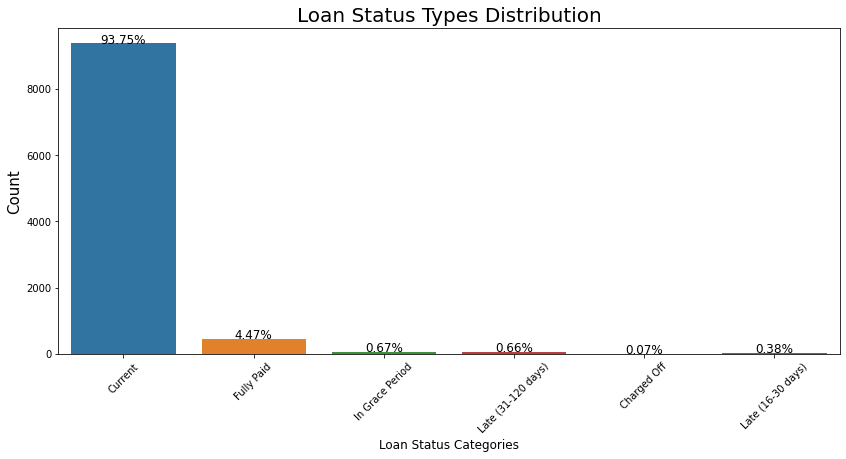

In [29]:
total = len(df)

plt.figure(figsize = (14,6))

g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Loan Status Categories", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Types Distribution", fontsize=20)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

plt.show()

**Observations**


1.   The dataset has 93.75% of active customers, followed by 4.47% of Fully Paid customers.
2.   0.38% of customers had Late pay loan status.



**Loan Purpose**

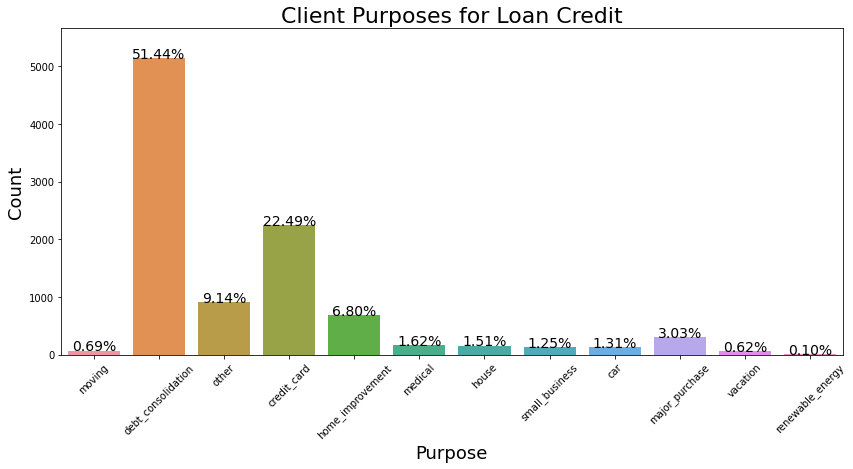

In [30]:
plt.figure(figsize=(14,6))

g = sns.countplot(x='loan_purpose', data=df)
g.set_title("Client Purposes for Loan Credit", fontsize=22)
g.set_xlabel("Purpose", fontsize=18)
g.set_ylabel('Count', fontsize=18)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.10)
g.set_xticklabels(g.get_xticklabels(),
                  rotation=45)

plt.show()

**Observations**


1.   From the above bar plot, it is evident that the majority of the loans are due to debt consolidation and credit card bills.
2.   We can also observe that only 0.1% of people secured loans for renewable energy



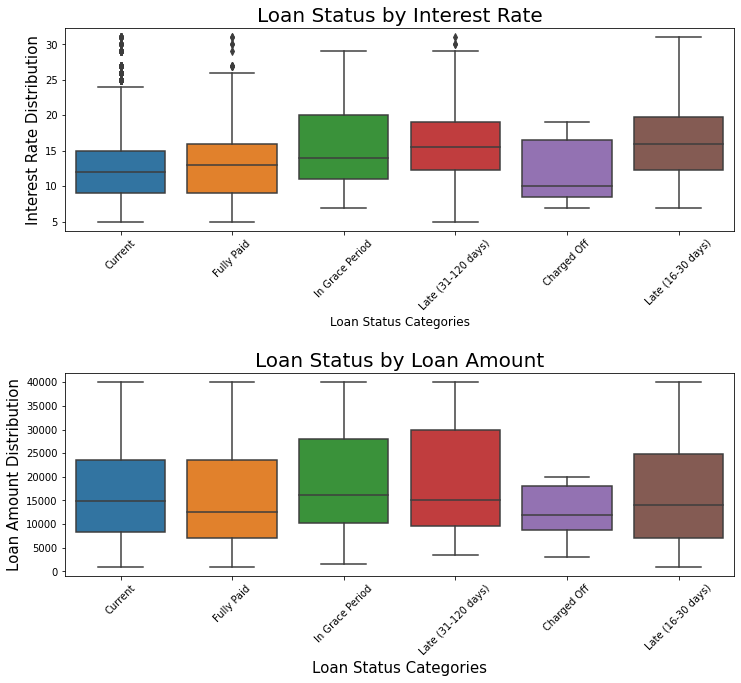

In [31]:
sns.color_palette("light:b", as_cmap=True)
df['int_round'] = df['interest_rate'].round(0).astype(int)
plt.figure(figsize = (12,16))

plt.subplot(311)
g1 = sns.boxplot(x="loan_status", y="int_round", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Loan Status Categories", fontsize=12)
g1.set_ylabel("Interest Rate Distribution", fontsize=15)
g1.set_title("Loan Status by Interest Rate", fontsize=20)

plt.subplot(312)
g2 = sns.boxplot(x="loan_status", y="loan_amount", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Loan Status Categories", fontsize=15)
g2.set_ylabel("Loan Amount Distribution", fontsize=15)
g2.set_title("Loan Status by Loan Amount", fontsize=20)

plt.subplots_adjust(hspace = 0.7,top = 0.9)
plt.show()

**Observations**


1.  Above box plots clearly state that the interest rates are high(16%) for the customers who pay late.
2.  The interest rate is low(around 10%) for the customers who had charged off.
3.  We can observe that the customers with Grace period and Current status received more loan amount of 15000 and charged off customers received less loan amount closer to $13000.






**Impact of Customer Grade**

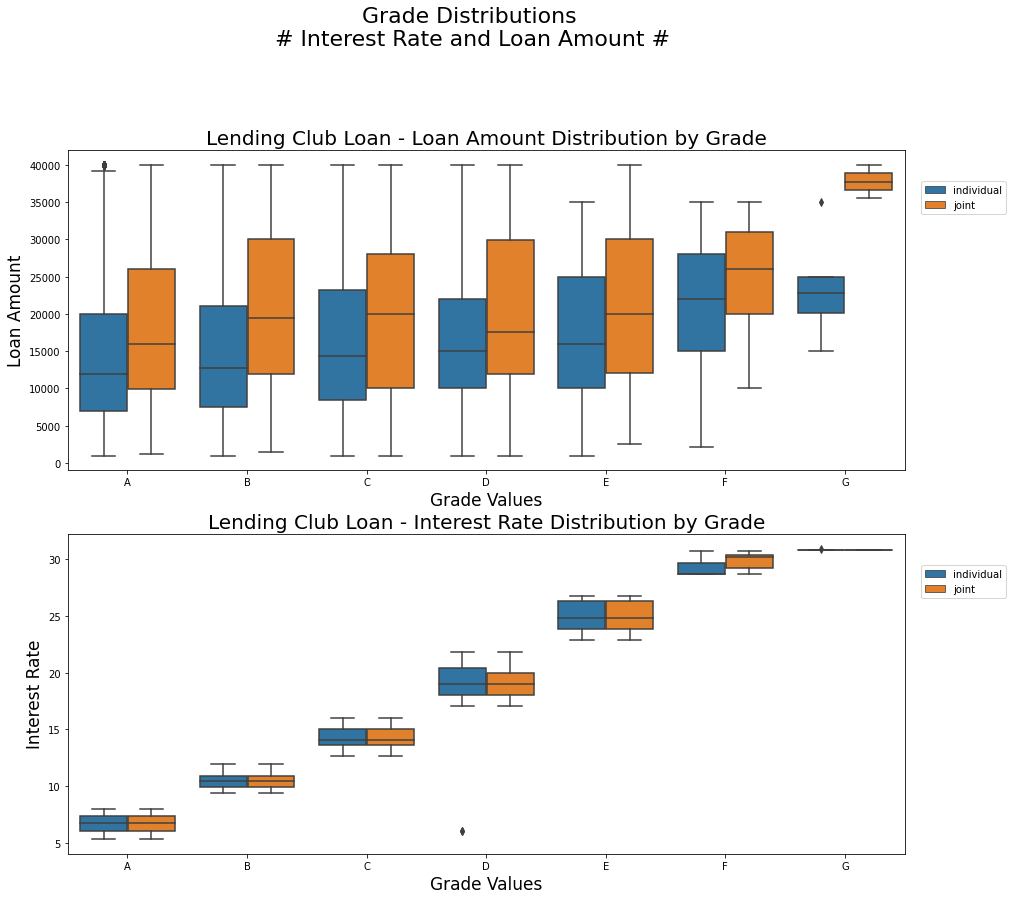

In [32]:
order_sub = df.groupby("sub_grade")['interest_rate'].count().index

plt.figure(figsize=(15,20))

plt.suptitle('Grade Distributions \n# Interest Rate and Loan Amount #', fontsize=22)

plt.subplot(311)
g = sns.boxplot(x="grade", y="loan_amount", data=df, hue="application_type", 
                order=["A",'B','C','D','E','F', 'G'])
g.set_xlabel("Grade Values", fontsize=17)
g.set_ylabel("Loan Amount", fontsize=17)
g.set_title("Lending Club Loan - Loan Amount Distribution by Grade", fontsize=20)
g.legend(loc='upper right')
plt.legend(loc=(1.02,0.8))

plt.subplot(312)
g1 = sns.boxplot(x='grade', y="interest_rate",data=df, 
               hue="application_type",  
               order=["A",'B','C','D','E','F', 'G'])
g1.set_xlabel("Grade Values", fontsize=17)
g1.set_ylabel("Interest Rate", fontsize=17)
g1.set_title("Lending Club Loan - Interest Rate Distribution by Grade", fontsize=20)
plt.legend(loc=(1.02,0.8))

plt.show()

**Observations**


1.   It is clearly evident that customers with Grade G will be approved with higher loan amounts of $36000 and they pay hight interest rate of 30.9%.
2.   Customers who falls under grade A, will given loan with very low intrest rates around 7.5%.
3.   Joint account customers have higher interset rates and higher loan amounts than individaul account holders.



## **Interest Rate Prediction**

**Feature** **Engineering**

In [33]:
output =['interest_rate']

**Feature Division**

In [34]:
#Categorical Features
cat_features = ['emp_title','state', 'homeownership', 'verified_income','verification_income_joint','loan_purpose','application_type','grade','sub_grade' ,'loan_status','initial_listing_status','disbursement_method' ]
for col in cat_features:
  df[col]=df[col].fillna('Nan')


In [35]:
#Date Features
dat_features_mm_yy = ['issue_month']
dat_features_yy = ['earliest_credit_line'] 
dat_features = ['issue_month','earliest_credit_line']

In [36]:
#Valued Features
float_features= []
for col in df.columns:
  if col not in cat_features and col not in dat_features and col not in output:
    if df[col].nunique() > 1:
      
      float_features.append(col)
    else:
      del df[col]


      


**Zero Imputation**

In [37]:
for col in float_features:
  df[col]=df[col].fillna(0)

In [38]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees,int_round
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,0.0,Nan,0.00,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0,14
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,0.0,Nan,0.00,0,0.0,1996,1,30,14,28800,4321,0,1,0.0,0,0,0,11,8.0,14,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0,13
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,0.0,Nan,0.00,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0,17
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,0.0,Nan,0.00,0,0.0,2007,0,4,4,25400,4997,0,1,0.0,0,0,1,1,15.0,4,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0,7
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,0.0,2008,7,22,16,69839,52722,0,0,0.0,0,0,1,6,4.0,16,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0,14


**Label Encoding for categorical Attributes**

In [39]:
for col in cat_features:
  le = LabelEncoder()
  # print(df[col].head())
  df[col] = le.fit_transform(df[col])
  output = open(str(col)+'.pkl', 'wb')
  pickle.dump(le, output)
  output.close()


In [40]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees,int_round
0,1778,3.0,30,0,90000.0,2,18.01,0.0,0,0.00,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0,2,11100,14,8,6,1,92.9,0,0,7,0,28000,60,14.07,652.53,2,12,Mar-2018,1,1,0,27015.86,1999.33,984.14,1015.19,0.0,14
1,4676,10.0,11,2,40000.0,0,5.04,0.0,0,0.00,0,0.0,1996,1,30,14,28800,4321,0,1,0.0,0,0,0,11,8.0,14,0,3,16500,24,14,4,0,100.0,0,1,2,0,5000,36,12.61,167.54,2,10,Feb-2018,1,1,0,4651.37,499.12,348.63,150.49,0.0,13
2,208,3.0,47,2,40000.0,1,21.15,0.0,0,0.00,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0,3,4300,14,8,6,0,93.5,0,0,8,0,2000,36,17.09,71.40,3,15,Feb-2018,1,0,0,1824.63,281.80,175.37,106.43,0.0,17
3,1036,1.0,37,2,30000.0,0,10.16,0.0,0,0.00,0,0.0,2007,0,4,4,25400,4997,0,1,0.0,0,0,1,1,15.0,4,0,2,19400,3,3,2,0,100.0,1,0,2,0,21600,36,6.72,664.19,0,2,Jan-2018,1,1,0,18853.26,3312.89,2746.74,566.15,0.0,7
4,3711,10.0,4,2,35000.0,2,57.96,57000.0,3,37.66,0,0.0,2008,7,22,16,69839,52722,0,0,0.0,0,0,1,6,4.0,16,0,10,32700,20,15,13,0,100.0,0,0,1,1,23000,36,14.07,786.87,2,12,Mar-2018,1,1,0,21430.15,2324.65,1569.85,754.80,0.0,14


Normalization

In [41]:
#Normalize float features
for col in float_features:
  # normalizer = Normalizer()
  # df[col] = normalizer.fit_transform(df[col])
  df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())


In [42]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees,int_round
0,1778,0.3,30,0,0.039130,2,0.038393,0.000000,0,0.000000,0.0,0.322034,2001,0.206897,0.305882,0.196078,0.020908,0.041134,0.0,0.000000,0.296875,0.0,0.006272,0.057143,0.172414,0.208333,0.196078,0.0,0.06250,0.028704,0.187500,0.173913,0.139535,0.071429,0.917153,0.000000,0.000000,7,0,0.692308,1.0,14.07,0.404847,2,12,Mar-2018,1,1,0,0.675397,0.048026,0.024604,0.240769,0.0,0.346154
1,4676,1.0,11,2,0.017391,0,0.010744,0.000000,0,0.000000,0.0,0.000000,1996,0.034483,0.329412,0.274510,0.008506,0.004585,0.0,0.019231,0.000000,0.0,0.000000,0.000000,0.379310,0.333333,0.274510,0.0,0.09375,0.042669,0.343750,0.304348,0.093023,0.000000,1.000000,0.000000,0.333333,2,0,0.102564,0.0,12.61,0.089065,2,10,Feb-2018,1,1,0,0.116284,0.011989,0.008716,0.035691,0.0,0.307692
2,208,0.3,47,2,0.017391,1,0.045087,0.000000,0,0.000000,0.0,0.237288,2006,0.137931,0.341176,0.196078,0.007145,0.016977,0.0,0.000000,0.218750,0.0,0.002167,0.028571,0.448276,0.291667,0.196078,0.0,0.09375,0.011120,0.187500,0.173913,0.139535,0.000000,0.924154,0.000000,0.000000,8,0,0.025641,0.0,17.09,0.026468,3,15,Feb-2018,1,0,0,0.045616,0.006769,0.004384,0.025242,0.0,0.461538
3,1036,0.1,37,2,0.013043,0,0.021659,0.000000,0,0.000000,0.0,0.000000,2007,0.000000,0.023529,0.078431,0.007501,0.005302,0.0,0.019231,0.000000,0.0,0.000000,0.028571,0.034483,0.625000,0.078431,0.0,0.06250,0.050168,0.015625,0.065217,0.046512,0.000000,1.000000,0.019231,0.000000,2,0,0.528205,0.0,6.72,0.412439,0,2,Jan-2018,1,1,0,0.471331,0.079579,0.068668,0.134272,0.0,0.076923
4,3711,1.0,4,2,0.015217,2,0.123558,0.051818,3,0.941971,0.0,0.000000,2008,0.241379,0.235294,0.313725,0.020626,0.055941,0.0,0.000000,0.000000,0.0,0.000000,0.028571,0.206897,0.166667,0.313725,0.0,0.31250,0.084562,0.281250,0.326087,0.302326,0.000000,1.000000,0.000000,0.000000,1,1,0.564103,0.0,14.07,0.492317,2,12,Mar-2018,1,1,0,0.535754,0.055840,0.039246,0.179014,0.0,0.346154


In [43]:
#Date Features
for col in dat_features:
  df[col] = pd.to_datetime(df[col])
  df[col]=df[col].map(dt.datetime.toordinal)

In [44]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees,int_round
0,1778,0.3,30,0,0.039130,2,0.038393,0.000000,0,0.000000,0.0,0.322034,719163,0.206897,0.305882,0.196078,0.020908,0.041134,0.0,0.000000,0.296875,0.0,0.006272,0.057143,0.172414,0.208333,0.196078,0.0,0.06250,0.028704,0.187500,0.173913,0.139535,0.071429,0.917153,0.000000,0.000000,7,0,0.692308,1.0,14.07,0.404847,2,12,736754,1,1,0,0.675397,0.048026,0.024604,0.240769,0.0,0.346154
1,4676,1.0,11,2,0.017391,0,0.010744,0.000000,0,0.000000,0.0,0.000000,719163,0.034483,0.329412,0.274510,0.008506,0.004585,0.0,0.019231,0.000000,0.0,0.000000,0.000000,0.379310,0.333333,0.274510,0.0,0.09375,0.042669,0.343750,0.304348,0.093023,0.000000,1.000000,0.000000,0.333333,2,0,0.102564,0.0,12.61,0.089065,2,10,736726,1,1,0,0.116284,0.011989,0.008716,0.035691,0.0,0.307692
2,208,0.3,47,2,0.017391,1,0.045087,0.000000,0,0.000000,0.0,0.237288,719163,0.137931,0.341176,0.196078,0.007145,0.016977,0.0,0.000000,0.218750,0.0,0.002167,0.028571,0.448276,0.291667,0.196078,0.0,0.09375,0.011120,0.187500,0.173913,0.139535,0.000000,0.924154,0.000000,0.000000,8,0,0.025641,0.0,17.09,0.026468,3,15,736726,1,0,0,0.045616,0.006769,0.004384,0.025242,0.0,0.461538
3,1036,0.1,37,2,0.013043,0,0.021659,0.000000,0,0.000000,0.0,0.000000,719163,0.000000,0.023529,0.078431,0.007501,0.005302,0.0,0.019231,0.000000,0.0,0.000000,0.028571,0.034483,0.625000,0.078431,0.0,0.06250,0.050168,0.015625,0.065217,0.046512,0.000000,1.000000,0.019231,0.000000,2,0,0.528205,0.0,6.72,0.412439,0,2,736695,1,1,0,0.471331,0.079579,0.068668,0.134272,0.0,0.076923
4,3711,1.0,4,2,0.015217,2,0.123558,0.051818,3,0.941971,0.0,0.000000,719163,0.241379,0.235294,0.313725,0.020626,0.055941,0.0,0.000000,0.000000,0.0,0.000000,0.028571,0.206897,0.166667,0.313725,0.0,0.31250,0.084562,0.281250,0.326087,0.302326,0.000000,1.000000,0.000000,0.000000,1,1,0.564103,0.0,14.07,0.492317,2,12,736754,1,1,0,0.535754,0.055840,0.039246,0.179014,0.0,0.346154


**Train Test Split**

In [45]:
Y = df['interest_rate']
X = df.drop(['interest_rate'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.3, random_state = 5)

**Linear Regression Model**

In [46]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [47]:
print(f'bias = {lr_model.intercept_}')
print(f'weights = {lr_model.coef_}')

bias = -3043.0804795060335
weights = [-8.93958399e-07  8.57943752e-03 -7.11636961e-05 -3.11876059e-03
 -1.01231701e-03  1.36105667e-03 -1.79386934e-01  2.47061673e-01
  1.05063399e-02  2.68544189e-02 -1.59867266e-02 -4.01176095e-02
  3.57244171e-03 -5.86539605e-02  6.73307671e-02 -9.22787555e-01
  1.48275155e-01 -1.86149386e-01  4.22104211e-02 -1.20570911e-02
  2.38150734e-03 -2.47178498e-04  1.94173030e-01  1.94897171e-01
 -3.25472899e-02 -1.95798842e-02  6.34814242e-01  2.90941104e-04
 -1.87687516e-01  4.00081848e-01 -4.58704438e-02  1.90175001e-01
  1.11486381e-01 -4.70425581e-02 -1.09842867e-02 -1.11829133e-02
  2.23345478e-02  6.54521397e-04 -4.86875977e-02 -5.17703652e-01
  6.17495027e-02  5.45421051e-01  2.73306630e-02  7.37542261e-02
  6.50163948e-04 -5.26027900e-03  2.83641924e-02  2.63766288e-02
 -3.48455853e-03 -1.66620794e+05  1.60095213e+05  1.68759976e+04
  2.11995807e+02  2.33758770e+01]


**Testing**

In [48]:
y_pred = lr_model.predict(X_test)

**Model Evaluation**

In [51]:
print("Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred))
print("Mean Square Error: ",metrics.mean_squared_error(y_test,y_pred))
print("Rooot Mean Square Error: ",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Absolute Error:  0.20316780509230978
Mean Square Error:  0.06574416019268738
Rooot Mean Square Error:  0.2564062405494207


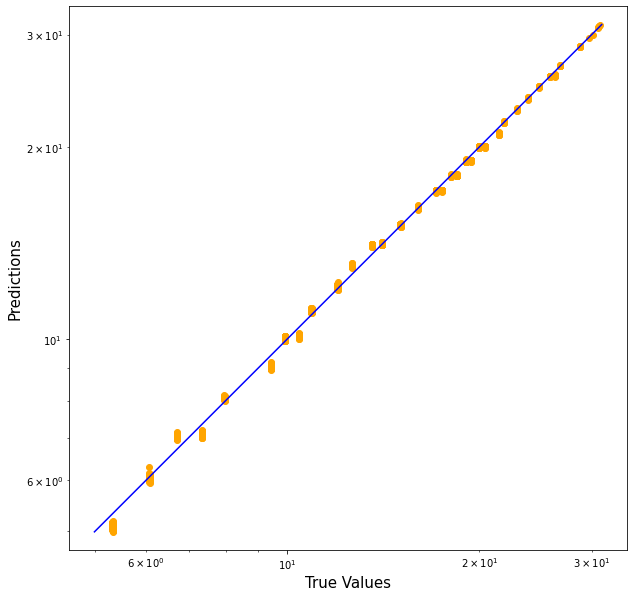

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='orange')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

**R Squared**

In [77]:
print("R Square :",metrics.r2_score(y_test,y_pred))

R Square : 0.9973899393074158


**XGBOOST Implementation**

In [79]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

[01:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**Testing**

In [80]:
y_pred_xg = xgb_model.predict(X_test)

**Model Evalaution**

In [81]:
print("Absolute Error: ",metrics.mean_absolute_error(y_test,y_pred_xg))
print("Mean Square Error: ",metrics.mean_squared_error(y_test,y_pred_xg))
print("Rooot Mean Square Error: ",np.sqrt(metrics.mean_squared_error(y_test,y_pred_xg)))

Absolute Error:  0.017445022214253668
Mean Square Error:  0.0016027860629270491
Rooot Mean Square Error:  0.04003481063933048


**R Squared**

In [82]:
print("R Square :",metrics.r2_score(y_test,y_pred_xg))

R Square : 0.9999363689658639


# **Assumptions:**


1.   We assumed that the missing customers in emp_title and emp_length attributes could be students, retired, self-employed and we assigned a value to the missing data using a label encoder.
2.   85.45% of data doesn’t have data for attributes like annual_income_joint, debt_to_income_joint and verification_income_joint. We can assume that these customers haven’t had any joint accounts and we imputed them with 0 value.

3.   Columns such as months_since_last_delinq, months_since_90d_late, months_since_last_credit_inquiry, debt_to_income were imputed with 0 based on the assumption that these customers don’t pay late.
5.   We considered outliers assuming that the corresponding data is probable.





1.   If I had more time, I would have done univariate, bi-variate, and multi-variate analyses.
2.   I would have made sure to use only some of the attributes rather than everything in the dataset.
3.   Nevertheless, I secured an R-square score of .99 which I believe had done the job well.